In [1]:
# packages
import os
import gc
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score, mean_squared_error, accuracy_score, mean_squared_error,log_loss
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
torch.__version__

'2.0.1'

In [3]:
EPOCHS = 2000
LR = 1e-3
BS = 32
SEED = 42
MODEL_NAME ='model_ver_2'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

In [4]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


In [5]:
df = pd.read_csv('./raw_data.csv')
df

,EQUIP_ID,MFG_DT,SALE_CD,MOLD_POS,REAL_POWER,CP,AX,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5
0,EQUIP1,2021-03-23,SALES 0,8,0.00,NaN,NaN,CORE1 A 02. 0570,CORE1 A 01. P3+3,CORE1 A 05. M0075,CORE1 A 8A. D-00,-6.4889,6.5811,0.00,0.12,0.12,0.12,0.25,0.25
1,EQUIP2,2021-03-23,SALES 1,1,-6.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,-6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50
2,EQUIP1,2021-03-25,SALES 2,2,0.00,NaN,NaN,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0000,CORE2 C 04. A-00,-7.3246,7.3802,0.00,0.12,0.12,0.25,0.25,0.25
3,EQUIP2,2021-03-25,SALES 3,6,-7.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,-6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62
4,EQUIP3,2021-04-09,SALES 4,1,-0.75,NaN,NaN,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,-7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175097,EQUIP13,2020-10-13,SALES 114,4,-5.25,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0850,CORE5 F 02. C-08,-6.3304,7.1881,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25
175098,EQUIP13,2020-10-14,SALES 114,5,-5.25,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0875,CORE5 F 02. D-08,-6.4933,6.8071,-5.25,-5.12,-5.12,-5.25,-5.25,-5.25
175099,EQUIP13,2020-10-16,SALES 114,6,-5.50,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+1,CORE5 F 02. M0950,CORE5 F 02. C-09,-6.3582,0.0000,-5.50,-5.37,-5.37,-5.50,-5.50,-5.50
175100,EQUIP35,2020-10-14,SALES 114,7,-8.00,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. P1+0,CORE5 F 02. M1350,CORE5 F 02. C-13,-6.3056,7.7866,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(df['MOLD_IN_TOP'].value_counts())
print(df['MOLD_IN_BOT'].value_counts())
print(df['MOLD_OUT_TOP'].value_counts())
print(df['MOLD_OUT_BOT'].value_counts())

MOLD_IN_TOP
CORE1 A 02. 0570    68090
CORE1 B 02. 0550    52320
CORE2 C 03. 0660    25794
CORE3 C 01. 0660    14370
CORE4 D 01. 0565     6220
CORE5 E 01. 0590     4442
CORE5 F 01. 0570     2260
CORE7 G 01. 0600      544
CORE2 J 03. 0650      480
CORE1 H 03. 0580      249
CORE2 K 01. 0670      197
CORE8 J 01. 0650       95
CORE7 I 01. 0610       32
CORE8 L 1-1 0630        9
Name: count, dtype: int64
MOLD_IN_BOT
CORE1 B 01. P2+1    16288
CORE1 A 01. P3+3    11767
CORE1 A 01. P2+3    10129
CORE1 A 01. P3+2     9956
CORE1 A 01. P2+2     9726
                    ...  
CORE2 J 01. M3+2        1
CORE2 J 01. OK+3        1
CORE4 D 01. OK+3        1
CORE8 J 01. M1+2        1
CORE5 F 01. OK+4        1
Name: count, Length: 221, dtype: int64
MOLD_OUT_TOP
CORE1 A 05. M0075    4185
CORE2 C 04. M0025    3604
CORE1 A 05. M0250    3371
CORE1 A 05. M0050    2847
CORE1 A 05. M0300    2792
                     ... 
CORE2 C 04. M1500       1
CORE1 A 05. P0100       1
CORE1 A 08. P0700       1
CORE8 J 02. M0

In [7]:
df.isnull().sum()

EQUIP_ID             0
MFG_DT               0
SALE_CD              0
MOLD_POS             0
REAL_POWER          13
CP              175102
AX              175102
MOLD_IN_TOP          0
MOLD_IN_BOT          0
MOLD_OUT_TOP         0
MOLD_OUT_BOT         0
IN_RADIUS            0
OUT_RADIUS           0
POWER              580
POWER1             530
POWER2             532
POWER3             537
POWER4             540
POWER5             551
dtype: int64

In [8]:
df_dropna = df.drop(['CP','AX','SALE_CD'],axis=1)

new_df = df_dropna.loc[df['REAL_POWER'] == df['POWER']].dropna(axis=0)
anomaly_df = df_dropna.loc[df['REAL_POWER'] != df['POWER']].dropna(axis=0)

new_df = new_df.loc[new_df['REAL_POWER'] < 0]
anomaly_df = anomaly_df.loc[anomaly_df['REAL_POWER'] < 0]

new_df = new_df.loc[new_df['POWER'] < 0]
anomaly_df = anomaly_df.loc[anomaly_df['POWER'] < 0]

new_df['MFG_DT'] = pd.to_datetime(new_df['MFG_DT'])
anomaly_df['MFG_DT'] = pd.to_datetime(anomaly_df['MFG_DT'])

new_df = new_df[new_df['MFG_DT'] >= np.datetime64('2020-01-01')]
anomlay_df = anomaly_df[anomaly_df['MFG_DT'] >= np.datetime64('2020-01-01')]

new_df = new_df.drop('MFG_DT', axis = 1)
anomaly_df = anomaly_df.drop('MFG_DT', axis=1)


new_df = new_df.loc[new_df['POWER'] > -20].dropna(axis=0)
anomaly_df = anomaly_df.loc[anomaly_df['POWER'] > -20].dropna(axis=0)



new_df['IN_RADIUS'] = abs(new_df['IN_RADIUS'])
new_df['OUT_RADIUS'] = abs(new_df['OUT_RADIUS'])
anomaly_df['IN_RADIUS'] = abs(anomaly_df['IN_RADIUS'])
anomaly_df['OUT_RADIUS'] = abs(anomaly_df['OUT_RADIUS'])
print(new_df.shape)
print(anomaly_df.shape)

(28607, 15)
(557, 15)


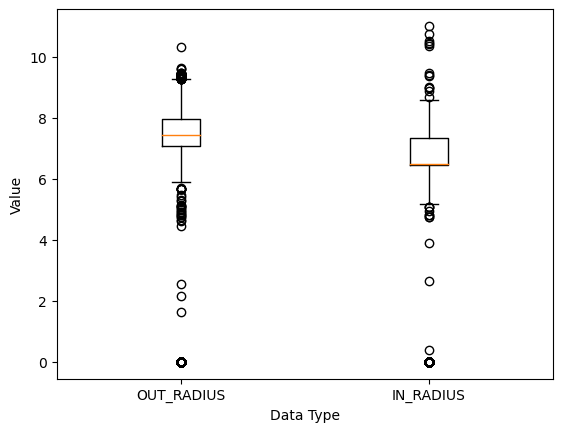

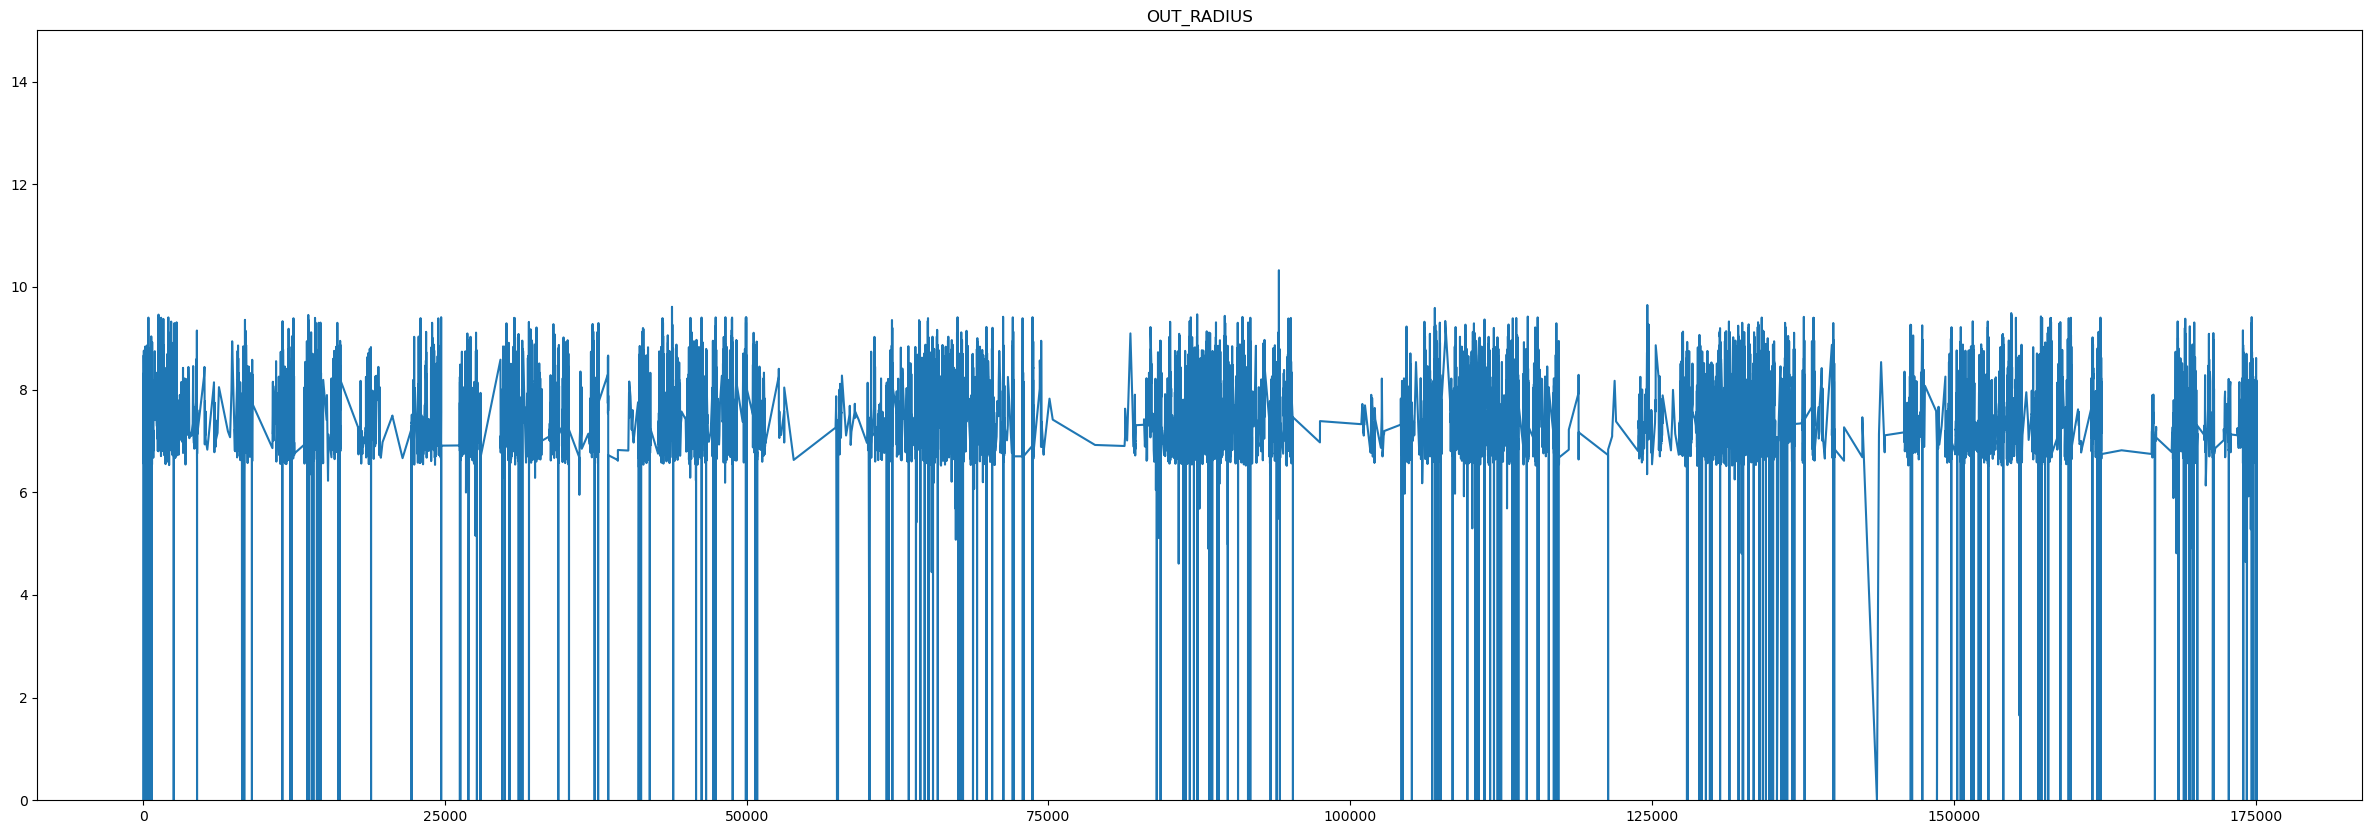

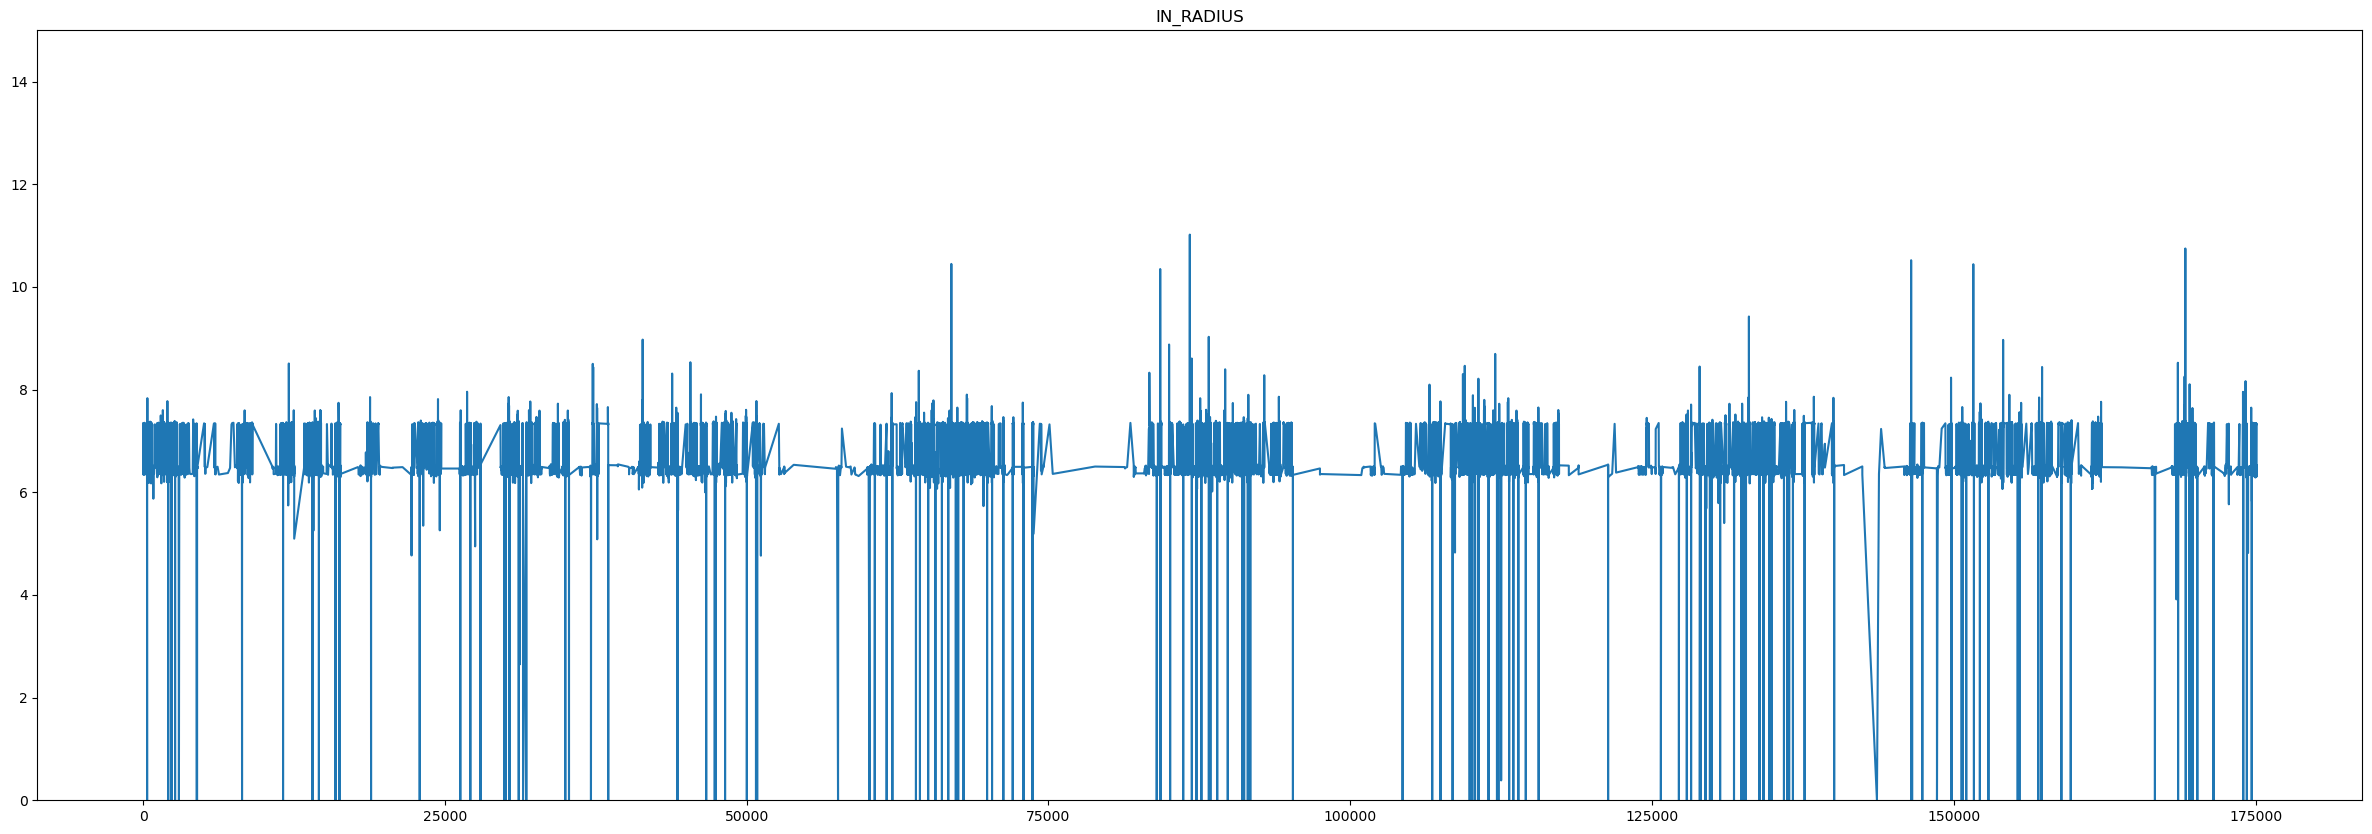

In [9]:
fig, ax = plt.subplots()

ax.boxplot([new_df['OUT_RADIUS'], new_df['IN_RADIUS']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
plt.xticks([1, 2], ['OUT_RADIUS','IN_RADIUS'])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['OUT_RADIUS'])
plt.title('OUT_RADIUS')
plt.ylim([0,15])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['IN_RADIUS'])
plt.title('IN_RADIUS')
plt.ylim([0,15])
plt.show()

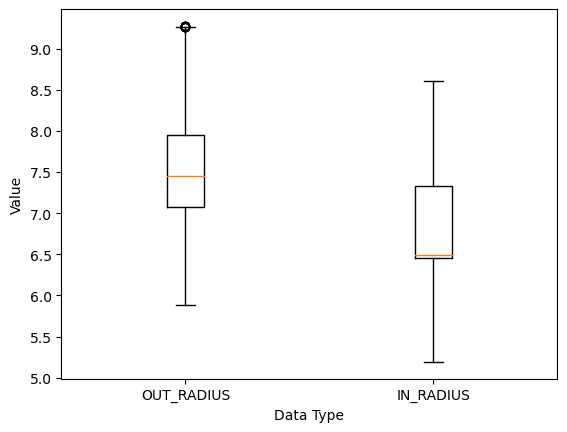

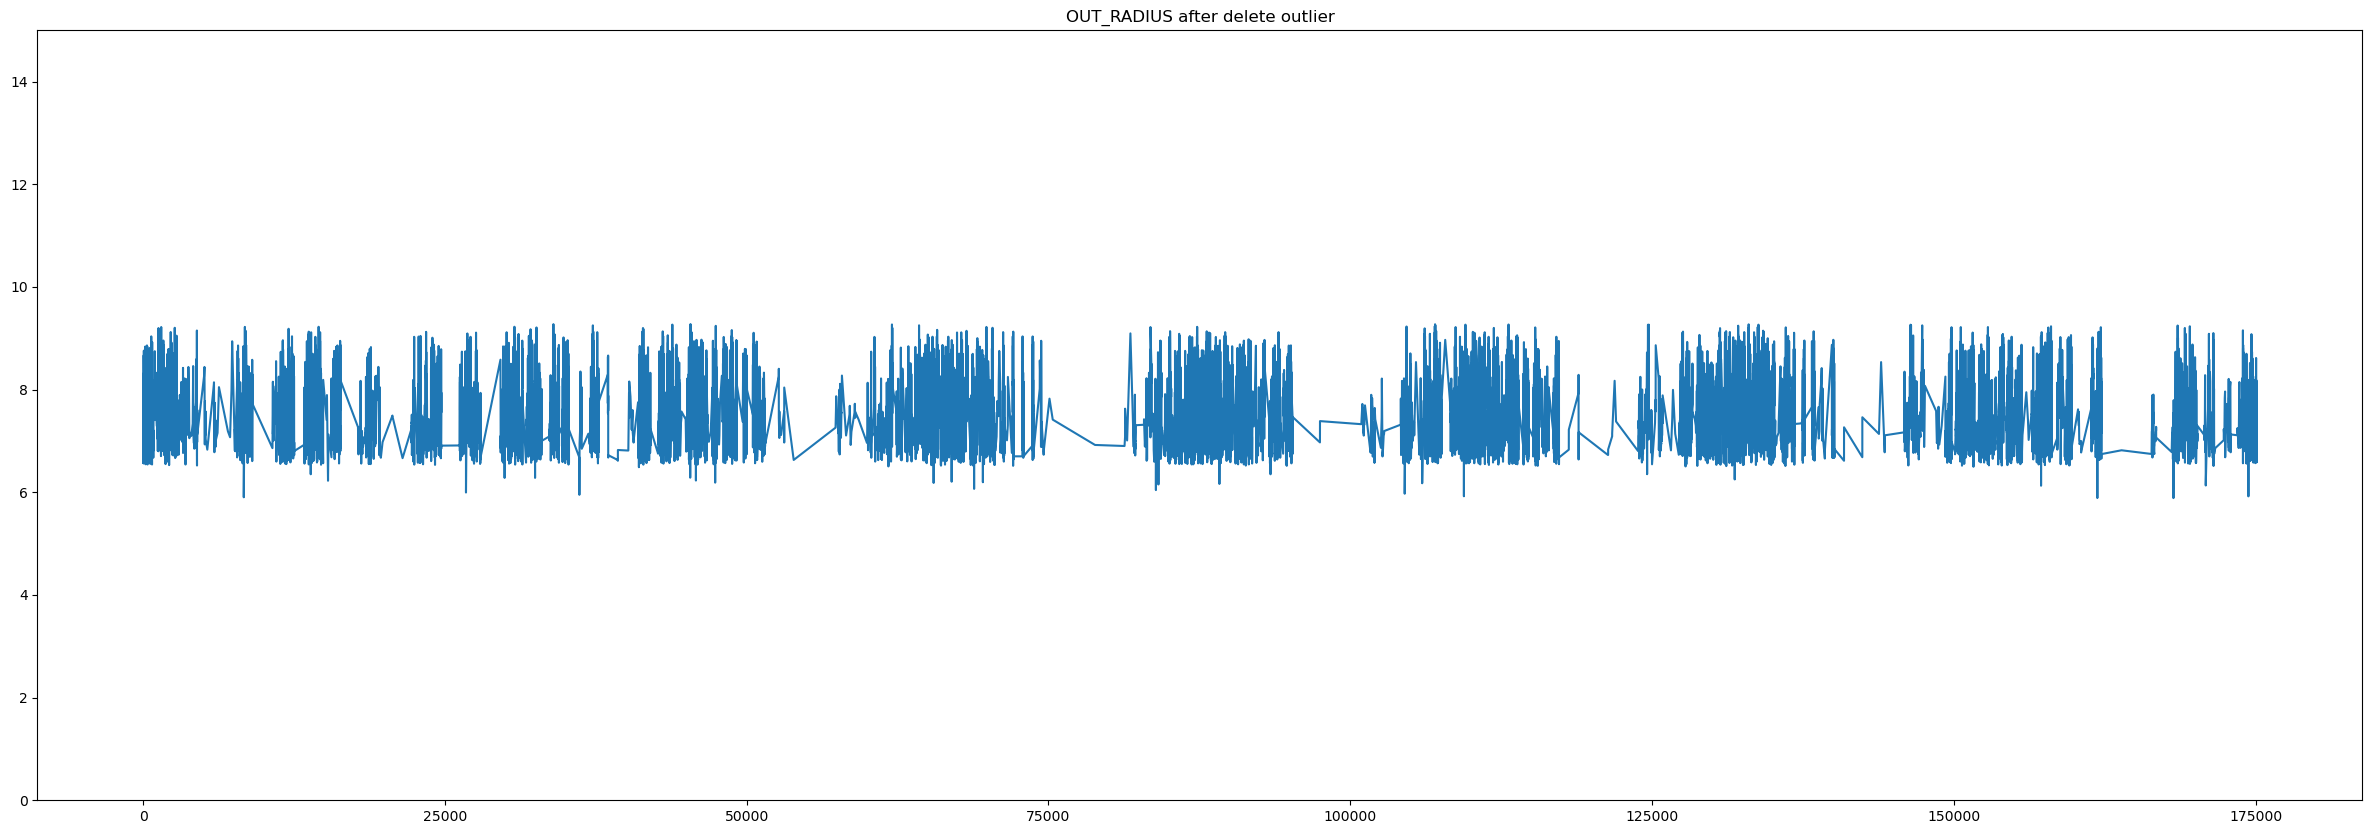

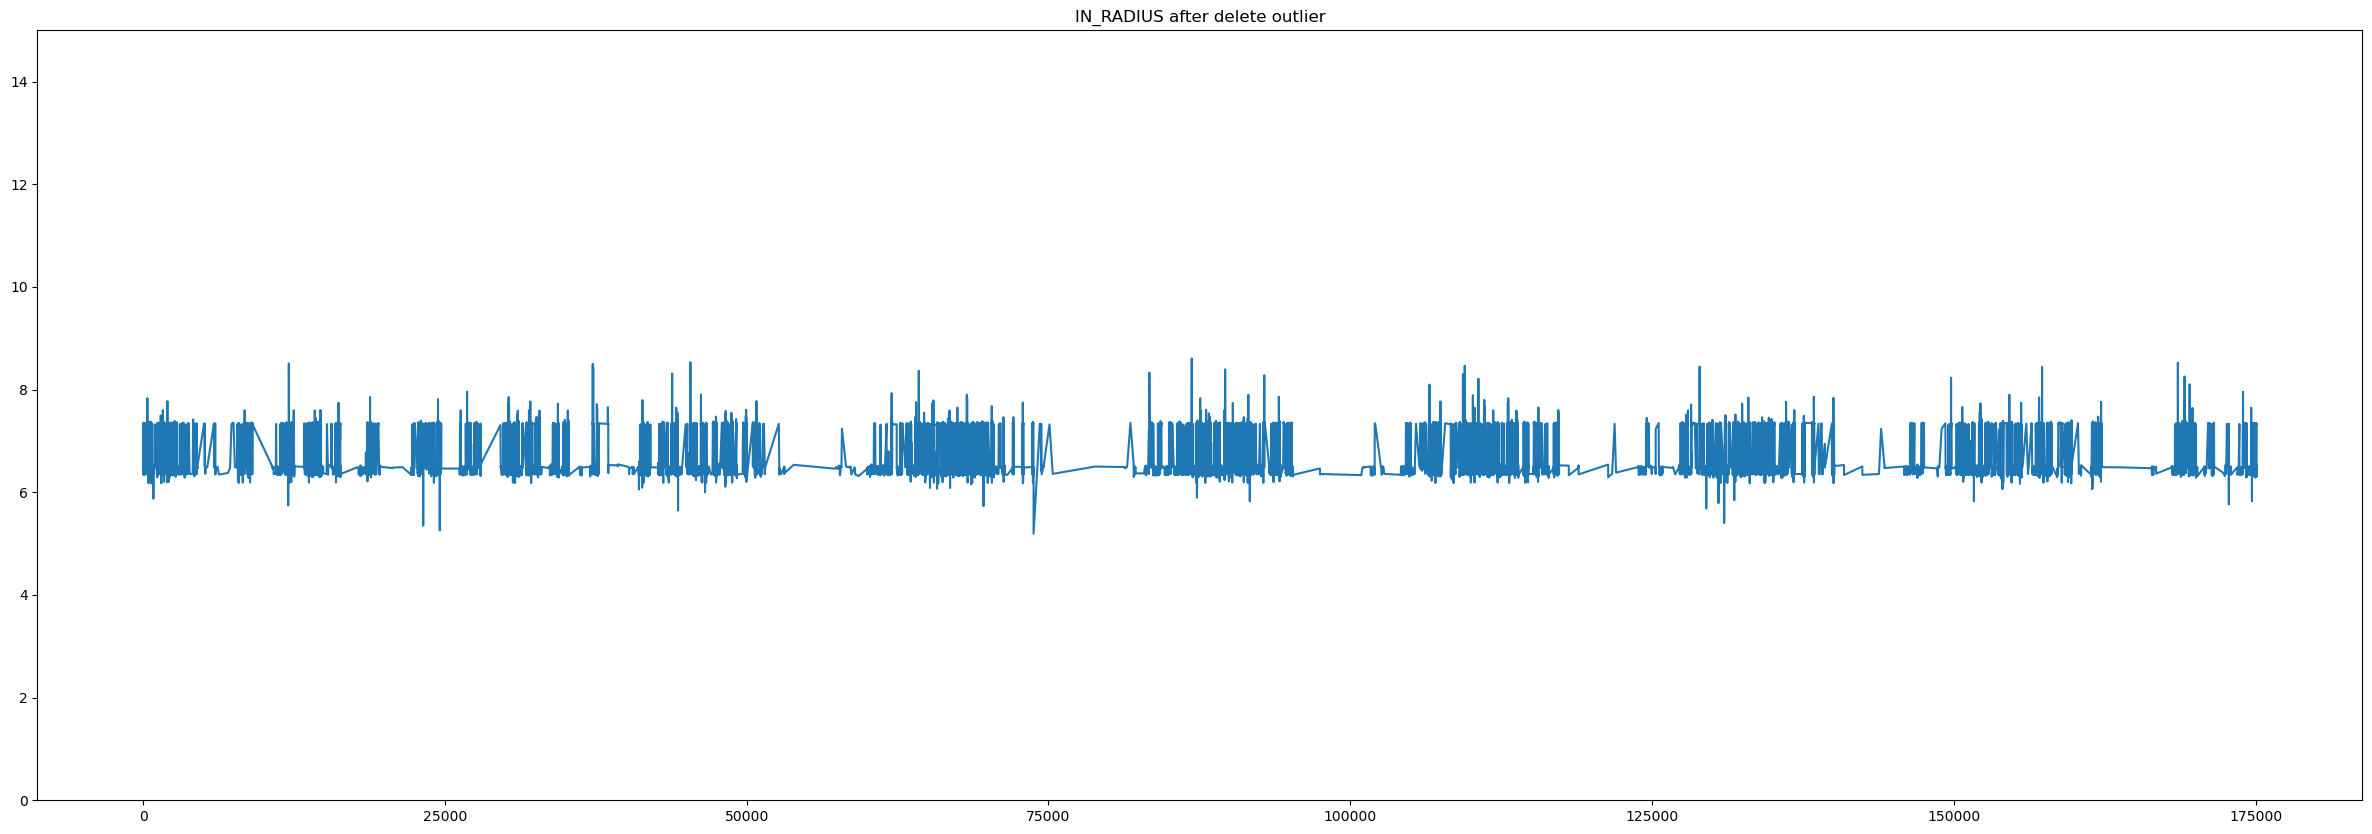

In [10]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_idx_in_rad = get_outlier(df=new_df, column='IN_RADIUS', weight=1.5)
new_df = new_df.drop(outlier_idx_in_rad,axis=0)
outlier_idx_out_rad = get_outlier(df=new_df, column='OUT_RADIUS', weight=1.5)
new_df = new_df.drop(outlier_idx_out_rad,axis=0)

outlier_idx_in_rad = get_outlier(df=anomaly_df, column='IN_RADIUS', weight=1.5)
anomaly_df = anomaly_df.drop(outlier_idx_in_rad,axis=0)
outlier_idx_out_rad = get_outlier(df=anomaly_df, column='OUT_RADIUS', weight=1.5)
anomaly_df = anomaly_df.drop(outlier_idx_out_rad,axis=0)

fig, ax = plt.subplots()

ax.boxplot([new_df['OUT_RADIUS'], new_df['IN_RADIUS']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
plt.xticks([1, 2], ['OUT_RADIUS','IN_RADIUS'])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['OUT_RADIUS'])
plt.title('OUT_RADIUS after delete outlier')
plt.ylim([0,15])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['IN_RADIUS'])
plt.title('IN_RADIUS after delete outlier')
plt.ylim([0,15])
plt.show()

In [11]:
new_df['target'] = 0
anomaly_df['target'] = 1

In [12]:
new_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
1,EQUIP2,1,-6.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50,0
3,EQUIP2,6,-7.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62,0
4,EQUIP3,1,-0.75,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87,0
5,EQUIP4,8,-4.00,CORE1 A 02. 0570,CORE1 A 01. P1+2,CORE1 A 05. M0650,CORE1 A 08. C-06,6.4829,7.1508,-4.00,-4.00,-3.87,-3.87,-4.12,-4.12,0
6,EQUIP5,6,-8.50,CORE1 A 02. 0570,CORE1 A 01. P3+2,CORE1 A 05. M1550,CORE1 A 08. C-15,6.4800,8.2939,-8.50,-8.25,-8.25,-8.37,-8.37,-8.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175095,EQUIP37,1,-4.00,CORE5 F 01. 0570,CORE5 F 01. OK+1,CORE5 F 02. M0675,CORE5 F 02. D-06,6.3326,6.9997,-4.00,-4.12,-4.12,-4.00,-4.00,-4.00,0
175096,EQUIP37,8,-4.75,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0775,CORE5 F 02. D-07,6.3279,7.0979,-4.75,-4.75,-4.75,-4.75,-4.75,-4.75,0
175097,EQUIP13,4,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0850,CORE5 F 02. C-08,6.3304,7.1881,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25,0
175098,EQUIP13,5,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0875,CORE5 F 02. D-08,6.4933,6.8071,-5.25,-5.12,-5.12,-5.25,-5.25,-5.25,0


In [13]:
anomaly_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
121,EQUIP15,4,-3.25,CORE1 A 02. 0570,CORE1 A 01. P2+2,CORE1 A 05. M0625,CORE1 A 08. B-06,6.4741,7.1521,-3.50,-3.37,-3.37,-3.50,-3.50,-3.50,1
2297,EQUIP27,2,-8.00,CORE2 C 03. 0660,CORE2 C 03. P1-2,CORE2 C 04. M0475,CORE2 C 04. D-04,7.3455,7.9546,-3.50,-3.50,-3.50,-3.37,-3.37,-3.37,1
2893,EQUIP13,7,-5.00,CORE1 B 02. 0550,CORE1 B 01. P2+0,CORE1 B 02. M0850,CORE1 B 02. C-08,7.2074,6.3643,-5.25,-5.25,-5.25,-5.25,-5.00,-5.00,1
3175,EQUIP26,6,-6.00,CORE2 C 03. 0660,CORE2 C 03. OK+2,CORE2 C 04. M0925,CORE2 C 04. B-09,8.5852,7.3512,-6.50,-6.50,-6.65,-6.75,-6.75,-6.75,1
4051,EQUIP2,3,-3.75,CORE3 C 01. 0660,CORE3 C 01. P1-1,CORE3 C 03. M0525,CORE3 C 03. B-05,8.0007,7.3452,-3.50,-3.50,-3.62,-3.62,-3.62,-3.62,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,EQUIP33,3,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0825,CORE5 F 02. B-08,7.1685,6.2684,-5.50,-5.50,-5.62,-5.62,-5.62,-5.62,1
174238,EQUIP16,5,-2.50,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0325,CORE2 C 04. B-03,7.3764,7.7534,-2.25,-2.25,-2.25,-2.25,-2.25,-2.37,1
174257,EQUIP12,6,-1.75,CORE5 E 01. 0590,CORE5 E 01. M2+0,CORE5 E 02. M0300,CORE5 E 02. A-03,6.5082,6.8625,-2.25,-2.25,-2.25,-2.12,-2.12,-2.12,1
174862,EQUIP7,8,-4.00,CORE5 E 01. 0590,CORE5 E 01. M1+0,CORE5 E 02. M0650,CORE5 E 02. C-06,6.5094,7.2148,-4.25,-4.25,-4.25,-4.25,-4.37,-4.37,1


In [14]:
data_df = pd.concat([new_df,anomaly_df])
data_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
1,EQUIP2,1,-6.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50,0
3,EQUIP2,6,-7.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62,0
4,EQUIP3,1,-0.75,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87,0
5,EQUIP4,8,-4.00,CORE1 A 02. 0570,CORE1 A 01. P1+2,CORE1 A 05. M0650,CORE1 A 08. C-06,6.4829,7.1508,-4.00,-4.00,-3.87,-3.87,-4.12,-4.12,0
6,EQUIP5,6,-8.50,CORE1 A 02. 0570,CORE1 A 01. P3+2,CORE1 A 05. M1550,CORE1 A 08. C-15,6.4800,8.2939,-8.50,-8.25,-8.25,-8.37,-8.37,-8.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,EQUIP33,3,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0825,CORE5 F 02. B-08,7.1685,6.2684,-5.50,-5.50,-5.62,-5.62,-5.62,-5.62,1
174238,EQUIP16,5,-2.50,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0325,CORE2 C 04. B-03,7.3764,7.7534,-2.25,-2.25,-2.25,-2.25,-2.25,-2.37,1
174257,EQUIP12,6,-1.75,CORE5 E 01. 0590,CORE5 E 01. M2+0,CORE5 E 02. M0300,CORE5 E 02. A-03,6.5082,6.8625,-2.25,-2.25,-2.25,-2.12,-2.12,-2.12,1
174862,EQUIP7,8,-4.00,CORE5 E 01. 0590,CORE5 E 01. M1+0,CORE5 E 02. M0650,CORE5 E 02. C-06,6.5094,7.2148,-4.25,-4.25,-4.25,-4.25,-4.37,-4.37,1


In [15]:
data_df['POWER_MEAN'] = (data_df['POWER1'] + data_df['POWER2'] + data_df['POWER3'] + data_df['POWER4'] + data_df['POWER5']) / 5
df_final = data_df.drop(['POWER_MEAN','REAL_POWER','POWER1','POWER2','POWER3','POWER4','POWER5','MOLD_IN_BOT','MOLD_OUT_TOP','MOLD_OUT_BOT'],axis=1)
df_final

,EQUIP_ID,MOLD_POS,MOLD_IN_TOP,IN_RADIUS,OUT_RADIUS,POWER,target
1,EQUIP2,1,CORE1 B 02. 0550,6.3564,7.4551,-6.50,0
3,EQUIP2,6,CORE1 B 02. 0550,6.3600,7.6877,-7.50,0
4,EQUIP3,1,CORE3 C 01. 0660,7.3411,7.5236,-0.75,0
5,EQUIP4,8,CORE1 A 02. 0570,6.4829,7.1508,-4.00,0
6,EQUIP5,6,CORE1 A 02. 0570,6.4800,8.2939,-8.50,0
...,...,...,...,...,...,...,...
174123,EQUIP33,3,CORE5 F 01. 0570,7.1685,6.2684,-5.50,1
174238,EQUIP16,5,CORE2 C 03. 0660,7.3764,7.7534,-2.25,1
174257,EQUIP12,6,CORE5 E 01. 0590,6.5082,6.8625,-2.25,1
174862,EQUIP7,8,CORE5 E 01. 0590,6.5094,7.2148,-4.25,1


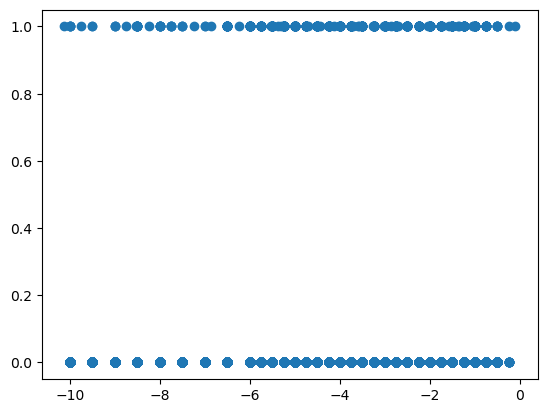

In [16]:
plt.scatter(df_final['POWER'], df_final['target'])

In [17]:
df_encoded = df_final

In [18]:
#df_encoded = pd.get_dummies(df_final,columns=['MOLD_POS','EQUIP_ID','MOLD_IN_TOP','MOLD_IN_BOT',"MOLD_OUT_TOP",'MOLD_OUT_BOT'])
df_encoded = pd.get_dummies(df_final,columns=['EQUIP_ID','MOLD_POS','MOLD_IN_TOP'])
df_encoded.reset_index(drop=True, inplace=True)
df_encoded

,IN_RADIUS,OUT_RADIUS,POWER,target,EQUIP_ID_EQUIP1,EQUIP_ID_EQUIP10,EQUIP_ID_EQUIP11,EQUIP_ID_EQUIP12,EQUIP_ID_EQUIP13,EQUIP_ID_EQUIP14,...,MOLD_IN_TOP_CORE1 B 02. 0550,MOLD_IN_TOP_CORE2 C 03. 0660,MOLD_IN_TOP_CORE2 J 03. 0650,MOLD_IN_TOP_CORE2 K 01. 0670,MOLD_IN_TOP_CORE3 C 01. 0660,MOLD_IN_TOP_CORE4 D 01. 0565,MOLD_IN_TOP_CORE5 E 01. 0590,MOLD_IN_TOP_CORE5 F 01. 0570,MOLD_IN_TOP_CORE7 G 01. 0600,MOLD_IN_TOP_CORE8 J 01. 0650
0,6.3564,7.4551,-6.50,0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,6.3600,7.6877,-7.50,0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,7.3411,7.5236,-0.75,0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,6.4829,7.1508,-4.00,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,6.4800,8.2939,-8.50,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28588,7.1685,6.2684,-5.50,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
28589,7.3764,7.7534,-2.25,1,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
28590,6.5082,6.8625,-2.25,1,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
28591,6.5094,7.2148,-4.25,1,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
df_encoded_normal = df_encoded.loc[df_encoded['target'] == 0]
df_encoded_anomaly = df_encoded.loc[df_encoded['target'] == 1]


In [20]:
df_encoded_anomaly

,IN_RADIUS,OUT_RADIUS,POWER,target,EQUIP_ID_EQUIP1,EQUIP_ID_EQUIP10,EQUIP_ID_EQUIP11,EQUIP_ID_EQUIP12,EQUIP_ID_EQUIP13,EQUIP_ID_EQUIP14,...,MOLD_IN_TOP_CORE1 B 02. 0550,MOLD_IN_TOP_CORE2 C 03. 0660,MOLD_IN_TOP_CORE2 J 03. 0650,MOLD_IN_TOP_CORE2 K 01. 0670,MOLD_IN_TOP_CORE3 C 01. 0660,MOLD_IN_TOP_CORE4 D 01. 0565,MOLD_IN_TOP_CORE5 E 01. 0590,MOLD_IN_TOP_CORE5 F 01. 0570,MOLD_IN_TOP_CORE7 G 01. 0600,MOLD_IN_TOP_CORE8 J 01. 0650
28070,6.4741,7.1521,-3.50,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28071,7.3455,7.9546,-3.50,1,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
28072,7.2074,6.3643,-5.25,1,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
28073,8.5852,7.3512,-6.50,1,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
28074,8.0007,7.3452,-3.50,1,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28588,7.1685,6.2684,-5.50,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
28589,7.3764,7.7534,-2.25,1,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
28590,6.5082,6.8625,-2.25,1,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
28591,6.5094,7.2148,-4.25,1,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [21]:
df_x = df_encoded_normal.drop('target',axis=1)

#df_y = df_encoded['POWER_MEAN']
#df_x = df_encoded.drop('POWER_MEAN',axis=1)
#df_y = df_encoded['REAL_POWER']
#df_x = df_encoded.drop('REAL_POWER',axis=1)

In [22]:
df_x

,IN_RADIUS,OUT_RADIUS,POWER,EQUIP_ID_EQUIP1,EQUIP_ID_EQUIP10,EQUIP_ID_EQUIP11,EQUIP_ID_EQUIP12,EQUIP_ID_EQUIP13,EQUIP_ID_EQUIP14,EQUIP_ID_EQUIP15,...,MOLD_IN_TOP_CORE1 B 02. 0550,MOLD_IN_TOP_CORE2 C 03. 0660,MOLD_IN_TOP_CORE2 J 03. 0650,MOLD_IN_TOP_CORE2 K 01. 0670,MOLD_IN_TOP_CORE3 C 01. 0660,MOLD_IN_TOP_CORE4 D 01. 0565,MOLD_IN_TOP_CORE5 E 01. 0590,MOLD_IN_TOP_CORE5 F 01. 0570,MOLD_IN_TOP_CORE7 G 01. 0600,MOLD_IN_TOP_CORE8 J 01. 0650
0,6.3564,7.4551,-6.50,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,6.3600,7.6877,-7.50,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,7.3411,7.5236,-0.75,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,6.4829,7.1508,-4.00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,6.4800,8.2939,-8.50,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28065,6.3326,6.9997,-4.00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
28066,6.3279,7.0979,-4.75,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
28067,6.3304,7.1881,-5.25,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
28068,6.4933,6.8071,-5.25,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [23]:
train_x, val_x = train_test_split(df_x, test_size = 0.2,random_state=SEED)
train_x.reset_index(drop=True, inplace=True)
val_x.reset_index(drop=True, inplace=True)

val_x, test_x = train_test_split(val_x, test_size = 0.5, random_state=SEED)
val_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [24]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(22456, 66)
(2807, 66)
(2807, 66)


In [25]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

In [26]:
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.Encoder = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),

        )
        self.Decoder = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,in_features),
        )

        self.init_weight()

    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)

In [27]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, mse_list = self.validation(self.model)
            
            mean_train_loss = np.mean(train_loss)
            print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}] val loss : [{val_loss}]\n')
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+'.pth')
                print("SAVE MODEL ~_~")
                
        print(best_loss)
           
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        mse_list = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                error = x-_x
                mse = np.mean(np.power(error.numpy(),2),axis=1)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                mse_list += mse.tolist()
        return np.mean(val_loss), mse_list

In [28]:
train_x_tensor = torch.tensor(train_x)
val_x_tensor = torch.tensor(val_x)

In [29]:
train_dataset = MyDataset(train_x_tensor)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataset = MyDataset(val_x_tensor)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)

In [30]:
it = iter(train_loader)
in_features = next(it)[0].shape[0]
in_features

66

In [31]:
#Train model
gc.collect()

seed_everything(SEED)
model = AutoEncoder(in_features)
#Using AdamW Optimizer
optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR, weight_decay=1e-1)#Opimizer : AdamW
#Using Learning Rate Scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
#trainer 객체 생성
trainer.fit()

Epoch : [1] Train loss : [0.03318183360212719] val loss : [0.023276818577538837]

SAVE MODEL ~_~
Epoch : [2] Train loss : [0.01993146538734436] val loss : [0.016028477005999197]

SAVE MODEL ~_~
Epoch : [3] Train loss : [0.015972080340667327] val loss : [0.014478206856768917]

SAVE MODEL ~_~
Epoch : [4] Train loss : [0.014548940017575297] val loss : [0.013330228108150715]

SAVE MODEL ~_~
Epoch : [5] Train loss : [0.013596849050372839] val loss : [0.012704451991753145]

SAVE MODEL ~_~
Epoch : [6] Train loss : [0.012970883460274958] val loss : [0.012197185508822176]

SAVE MODEL ~_~
Epoch : [7] Train loss : [0.012441836354558878] val loss : [0.011625763177025046]

SAVE MODEL ~_~
Epoch : [8] Train loss : [0.011688414870886042] val loss : [0.010522625324400988]

SAVE MODEL ~_~
Epoch : [9] Train loss : [0.01036977261885937] val loss : [0.008872574549803341]

SAVE MODEL ~_~
Epoch : [10] Train loss : [0.008968741229026873] val loss : [0.0073925852510993454]

SAVE MODEL ~_~
Epoch : [11] Train lo

Epoch : [90] Train loss : [0.00022228895191967545] val loss : [0.00013932852570261193]

SAVE MODEL ~_~
Epoch : [91] Train loss : [0.00022797177269530118] val loss : [0.00014495431126058313]

Epoch : [92] Train loss : [0.00022512821682762492] val loss : [0.0001899940618221246]

Epoch : [93] Train loss : [0.0002320608916677345] val loss : [0.00014430315691656276]

Epoch : [94] Train loss : [0.00022839158772800365] val loss : [0.0001496715768470577]

Epoch : [95] Train loss : [0.00022684610367519118] val loss : [0.00014546610778283636]

Epoch : [96] Train loss : [0.00021977634785026563] val loss : [0.0001506594534145155]

Epoch : [97] Train loss : [0.0002220915474472375] val loss : [0.00013325127520147362]

SAVE MODEL ~_~
Epoch : [98] Train loss : [0.0002258821692842754] val loss : [0.00013208824107509415]

SAVE MODEL ~_~
Epoch : [99] Train loss : [0.00022424272303287892] val loss : [0.0001362451515970778]

Epoch : [100] Train loss : [0.000219383322629201] val loss : [0.000134675721834686

Epoch : [180] Train loss : [0.00016496657070952888] val loss : [8.37423037658234e-05]

SAVE MODEL ~_~
Epoch : [181] Train loss : [0.00015287999574353214] val loss : [9.038448979481473e-05]

Epoch : [182] Train loss : [0.00015683757281299856] val loss : [7.958749669838157e-05]

SAVE MODEL ~_~
Epoch : [183] Train loss : [0.00015609511952540284] val loss : [8.268030395894047e-05]

Epoch : [184] Train loss : [0.0001607711177727737] val loss : [8.788261429386198e-05]

Epoch : [185] Train loss : [0.00015354240007519932] val loss : [8.867523803763271e-05]

Epoch : [186] Train loss : [0.00015978061213915766] val loss : [8.527414905240056e-05]

Epoch : [187] Train loss : [0.00015717186236353903] val loss : [8.954038391741712e-05]

Epoch : [188] Train loss : [0.00015518882501159133] val loss : [8.214805174330567e-05]

Epoch : [189] Train loss : [0.0001533904683996676] val loss : [8.24658709668504e-05]

Epoch : [190] Train loss : [0.0001578906126023271] val loss : [8.541489098041149e-05]

Epoch :

Epoch : [272] Train loss : [0.00013470941884694403] val loss : [8.065865747332943e-05]

Epoch : [273] Train loss : [0.00013991669050060967] val loss : [7.036099999492184e-05]

Epoch : [274] Train loss : [0.0001421482970817774] val loss : [7.480273769612144e-05]

Epoch 00274: reducing learning rate of group 0 to 1.2500e-04.
Epoch : [275] Train loss : [0.0001294673870779402] val loss : [6.299038239955156e-05]

SAVE MODEL ~_~
Epoch : [276] Train loss : [0.00012628179600898792] val loss : [6.953415084932534e-05]

Epoch : [277] Train loss : [0.00012300348486764584] val loss : [6.424336022932535e-05]

Epoch : [278] Train loss : [0.00012344264767960293] val loss : [6.346334895500728e-05]

Epoch : [279] Train loss : [0.00012722075514679779] val loss : [6.759586360451728e-05]

Epoch : [280] Train loss : [0.0001248411610706373] val loss : [6.370134580761673e-05]

Epoch : [281] Train loss : [0.00012664865397919828] val loss : [6.3807109158502e-05]

Epoch : [282] Train loss : [0.000122172301520513

Epoch : [363] Train loss : [0.00010993586806567987] val loss : [5.486538413441105e-05]

SAVE MODEL ~_~
Epoch : [364] Train loss : [0.00010934942538447531] val loss : [5.635237839256165e-05]

Epoch : [365] Train loss : [0.00011118352549316669] val loss : [5.629956903745055e-05]

Epoch : [366] Train loss : [0.00011043091173757377] val loss : [5.532577069350902e-05]

Epoch : [367] Train loss : [0.00010920184254984603] val loss : [5.5748540065988806e-05]

Epoch : [368] Train loss : [0.00011305391545359962] val loss : [5.7770042045293934e-05]

Epoch : [369] Train loss : [0.00010975654932810923] val loss : [5.685217816294012e-05]

Epoch : [370] Train loss : [0.00011005016316361164] val loss : [5.534869681220946e-05]

Epoch : [371] Train loss : [0.00011256688070654149] val loss : [5.5962201651544255e-05]

Epoch : [372] Train loss : [0.00011241278505808739] val loss : [5.8133242408654375e-05]

Epoch : [373] Train loss : [0.00011030199563909243] val loss : [5.475509051807008e-05]

SAVE MODEL ~_

KeyboardInterrupt: 

In [245]:
pretrained_model = torch.load('./' + MODEL_NAME+'.pth')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()
summary(pretrained_model)

Layer (type:depth-idx)                   Param #
AutoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       8,576
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       8,256
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       2,080
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       528
│    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-9                       544
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      2,112
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      8,320
│    └─ReLU: 2-14                        --
│    └─Linear: 2-15                      8,514
Total params: 38,930
Trainable params: 38,930
Non-trainable params: 0

In [246]:
df_x_anoamly = df_encoded_anomaly.drop('target', axis=1)

In [247]:
anomaly_val =  df_x_anoamly.iloc[:400,:]
anomaly_test = df_x_anoamly.iloc[400:,:]

anomaly_val = scaler.transform(anomaly_val)
anomaly_test = scaler.transform(anomaly_test)
anomaly_val_tensor = torch.tensor(anomaly_val)
anomaly_test_tensor = torch.tensor(anomaly_test)
normal_test_tensor = torch.tensor(test_x)
print(anomaly_val_tensor.shape)
print(anomaly_test_tensor.shape)
print(normal_test_tensor.shape)

torch.Size([400, 66])
torch.Size([123, 66])
torch.Size([2807, 66])


In [248]:
pretrained_model.eval()
val_loss = []
mse_list_normal = []
with torch.no_grad():
    for x in iter(val_loader):
        pred_tmp = []
        x = x.float().to(device)
        _x,_ = pretrained_model(x)
        error = x-_x
        mse = np.mean(np.power(error.numpy(),2),axis=1)
        mse_list_normal += mse.tolist()

In [249]:
mse_list_val_anomaly = []
with torch.no_grad():
    x = anomaly_val_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_val_anomaly += mse.tolist()

In [250]:
mse_list_test_normal = []
with torch.no_grad():
    x = normal_test_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_test_normal += mse.tolist()

In [251]:
mse_list_test_anomaly = []
with torch.no_grad():
    x = anomaly_test_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_test_anomaly += mse.tolist()

In [252]:
mse_list_test_anomaly

[3.565821771189803e-07,
 2.751123417965573e-07,
 1.9776287274453352e-07,
 0.011058577336370945,
 1.859363010225934e-07,
 2.1527843330204632e-07,
 0.0013820934109389782,
 6.754828064003959e-05,
 3.483260661596432e-05,
 2.6590245397528633e-05,
 5.563736522162799e-06,
 0.0005966137396171689,
 0.00011983954027527943,
 2.5262575945816934e-05,
 7.212976197479293e-05,
 0.00012907556083519012,
 0.03137662261724472,
 0.001097816857509315,
 9.880434663500637e-05,
 6.574105668732955e-07,
 0.00019035964214708656,
 0.00036455917870625854,
 3.94788476114627e-05,
 0.0011926500592380762,
 0.026497703045606613,
 0.0003833906666841358,
 1.978132360136442e-07,
 6.602828943869099e-05,
 8.710699148650747e-07,
 1.345834590438244e-07,
 3.898771683452651e-05,
 0.0013279813574627042,
 7.51222760300152e-05,
 0.000102282538136933,
 0.00012556486763060093,
 0.004123128484934568,
 0.0024568107910454273,
 5.322486686054617e-05,
 4.666308086598292e-06,
 2.4821554688969627e-05,
 0.00011184604227310047,
 1.28520255771

In [253]:
val_anomaly_count = 0
test_anomaly_count = 0
false_positive = 0 
thr_list = [(i+1) * 1e-7  for  i  in range(1,100)]
best_f1 = 0
best_thr = 0
best_fpr = 0
best_recall = 0
best_false_positive = 0
best_val_anomaly_count = 0
best_precision = 0
for thr in thr_list:
    val_anomaly_count = 0
    false_positive = 0 
    for i in range(len(mse_list_normal)):
        if mse_list_normal[i] > thr:
            false_positive = false_positive+1
    print(f"False Positive Count : {false_positive} / Whole Val Normal Data {str(len(mse_list_normal))} ")
    print(f"False Positive Rate : {false_positive/len(mse_list_normal):.5f}")
    print()
    for i in range(len(mse_list_val_anomaly)):
        if mse_list_val_anomaly[i] > thr:
            val_anomaly_count = val_anomaly_count+1
    print(f"Detect Anomaly in Val Data : {str(val_anomaly_count)} / Whole Val Data {str(len(mse_list_val_anomaly))} ")
    print(f"Recall : {val_anomaly_count/len(mse_list_val_anomaly):.5f}")
    print()

    print("Confusion matrix")
    print(f"[{len(mse_list_normal)-false_positive} {false_positive}]\n[{len(mse_list_val_anomaly)-val_anomaly_count} {val_anomaly_count}]")
    
    precision = val_anomaly_count / (val_anomaly_count + false_positive)
    recall = val_anomaly_count / len(mse_list_val_anomaly)
    f1_score = 2 * precision * recall/(precision+recall)
    print(f"F1-score : {f1_score:.5f}")
    print()
    
    '''if best_f1 < f1_score:
        best_f1 = f1_score
        best_thr = thr
        best_fpr = false_positive/len(mse_list_normal)
        best_recall = val_anomaly_count/len(mse_list_val_anomaly)
        best_val_anomaly_count = val_anomaly_count
        best_false_positive = false_positive'''
    if best_f1 < f1_score:
        best_f1 = f1_score
        best_thr = thr
        best_fpr = false_positive/len(mse_list_normal)
        best_recall = val_anomaly_count/len(mse_list_val_anomaly)
        best_val_anomaly_count = val_anomaly_count
        best_false_positive = false_positive
        best_precision = precision
print(f"Best F1 : {best_f1}")
print(f"Best False Positive Rate(Criterion : F1) : {best_fpr}")
print(f"Best? Recall(Creiterion : F1) : {best_recall}")
print(f"Best Threshold(Criterion : F1) : {best_thr}")
print(f"Best Precision(Criterion : F1) : {best_precision}")
print("Confusion matrix")
print(f"[{len(mse_list_normal)-best_false_positive} {best_false_positive}]\n[{len(mse_list_val_anomaly)-best_val_anomaly_count} {best_val_anomaly_count}]")


False Positive Count : 2031 / Whole Val Normal Data 2807 
False Positive Rate : 0.72355

Detect Anomaly in Val Data : 361 / Whole Val Data 400 
Recall : 0.90250

Confusion matrix
[776 2031]
[39 361]
F1-score : 0.25860

False Positive Count : 1511 / Whole Val Normal Data 2807 
False Positive Rate : 0.53830

Detect Anomaly in Val Data : 335 / Whole Val Data 400 
Recall : 0.83750

Confusion matrix
[1296 1511]
[65 335]
F1-score : 0.29831

False Positive Count : 1156 / Whole Val Normal Data 2807 
False Positive Rate : 0.41183

Detect Anomaly in Val Data : 317 / Whole Val Data 400 
Recall : 0.79250

Confusion matrix
[1651 1156]
[83 317]
F1-score : 0.33849

False Positive Count : 849 / Whole Val Normal Data 2807 
False Positive Rate : 0.30246

Detect Anomaly in Val Data : 299 / Whole Val Data 400 
Recall : 0.74750

Confusion matrix
[1958 849]
[101 299]
F1-score : 0.38630

False Positive Count : 645 / Whole Val Normal Data 2807 
False Positive Rate : 0.22978

Detect Anomaly in Val Data : 287 /

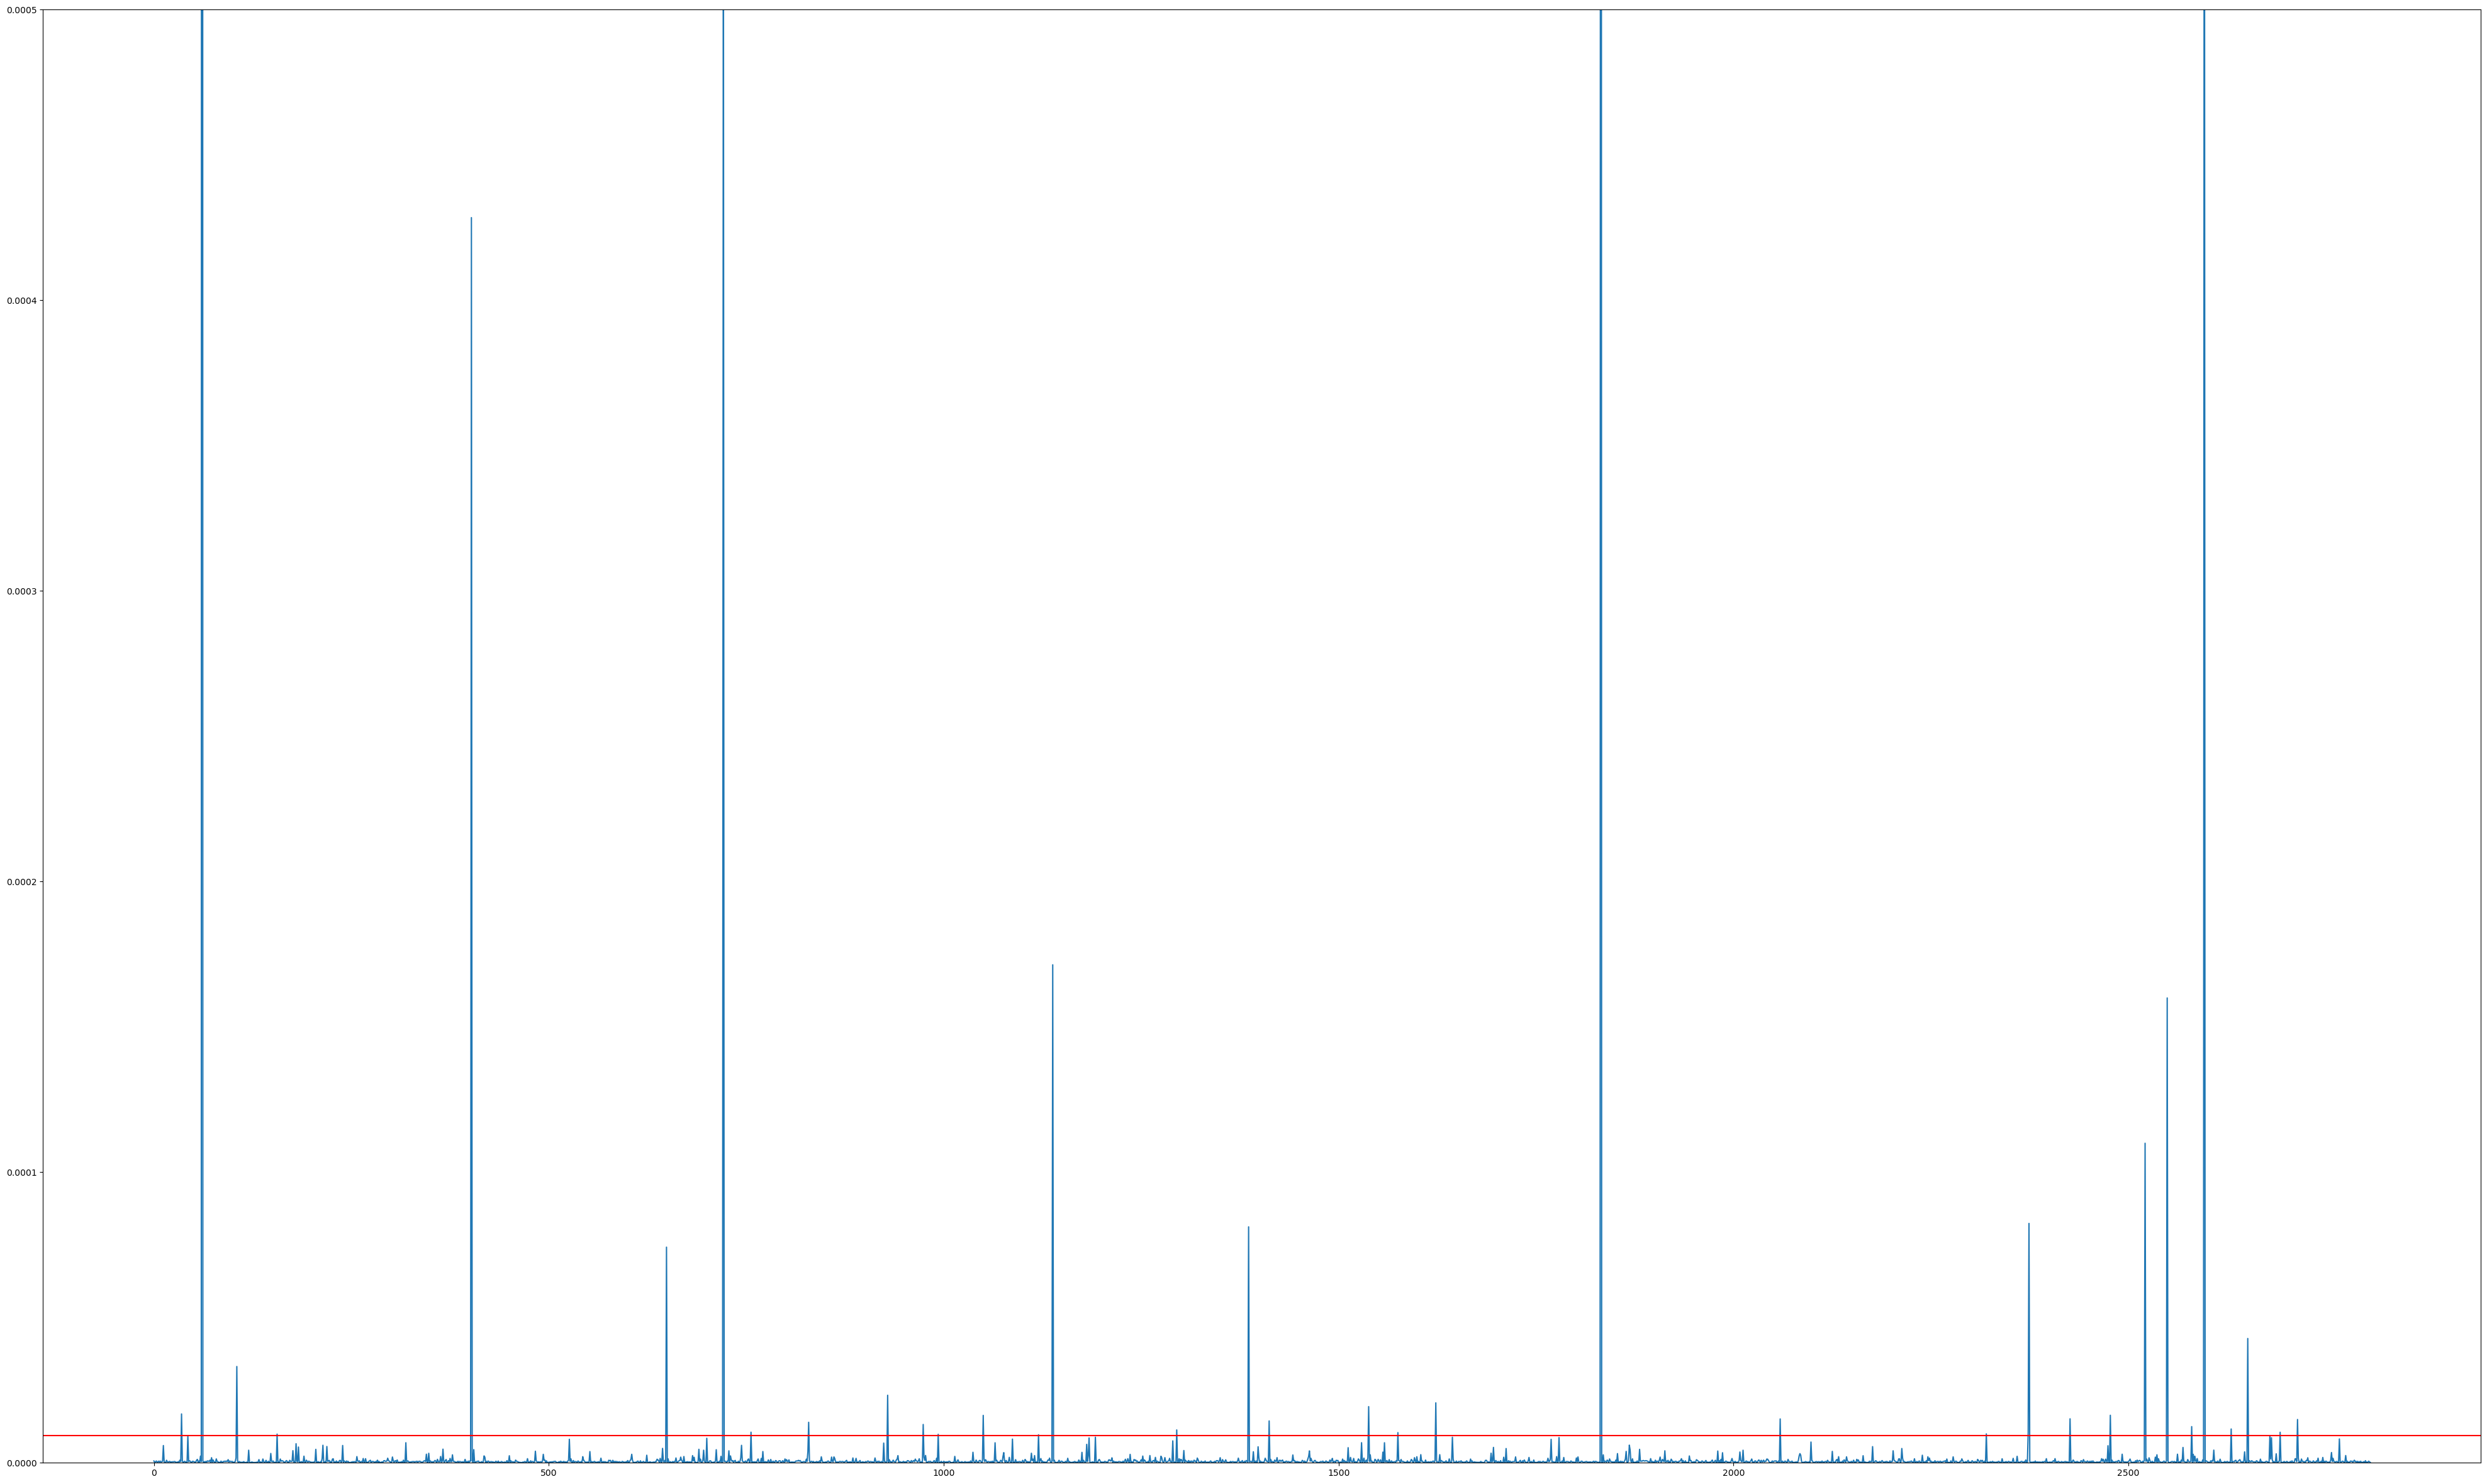

In [ ]:
plt.figure(figsize=(50,30))
plt.plot(mse_list_normal)
plt.axhline(best_thr, color='r')
plt.ylim([0,0.0005])
plt.show()
plt.figure(figsize=(50,30))
plt.plot(mse_list_val_anomaly)
plt.ylim([0,0.0005])
plt.axhline(best_thr, color='r')
plt.show()


Confusion matrix
[2773 34]
[54 69]
Detect Anomaly in Test Data : 69 / Whole Test Data 123 
Precision : 0.66990
Sensitivity : 0.98789
False-Positive Rate : 0.01211


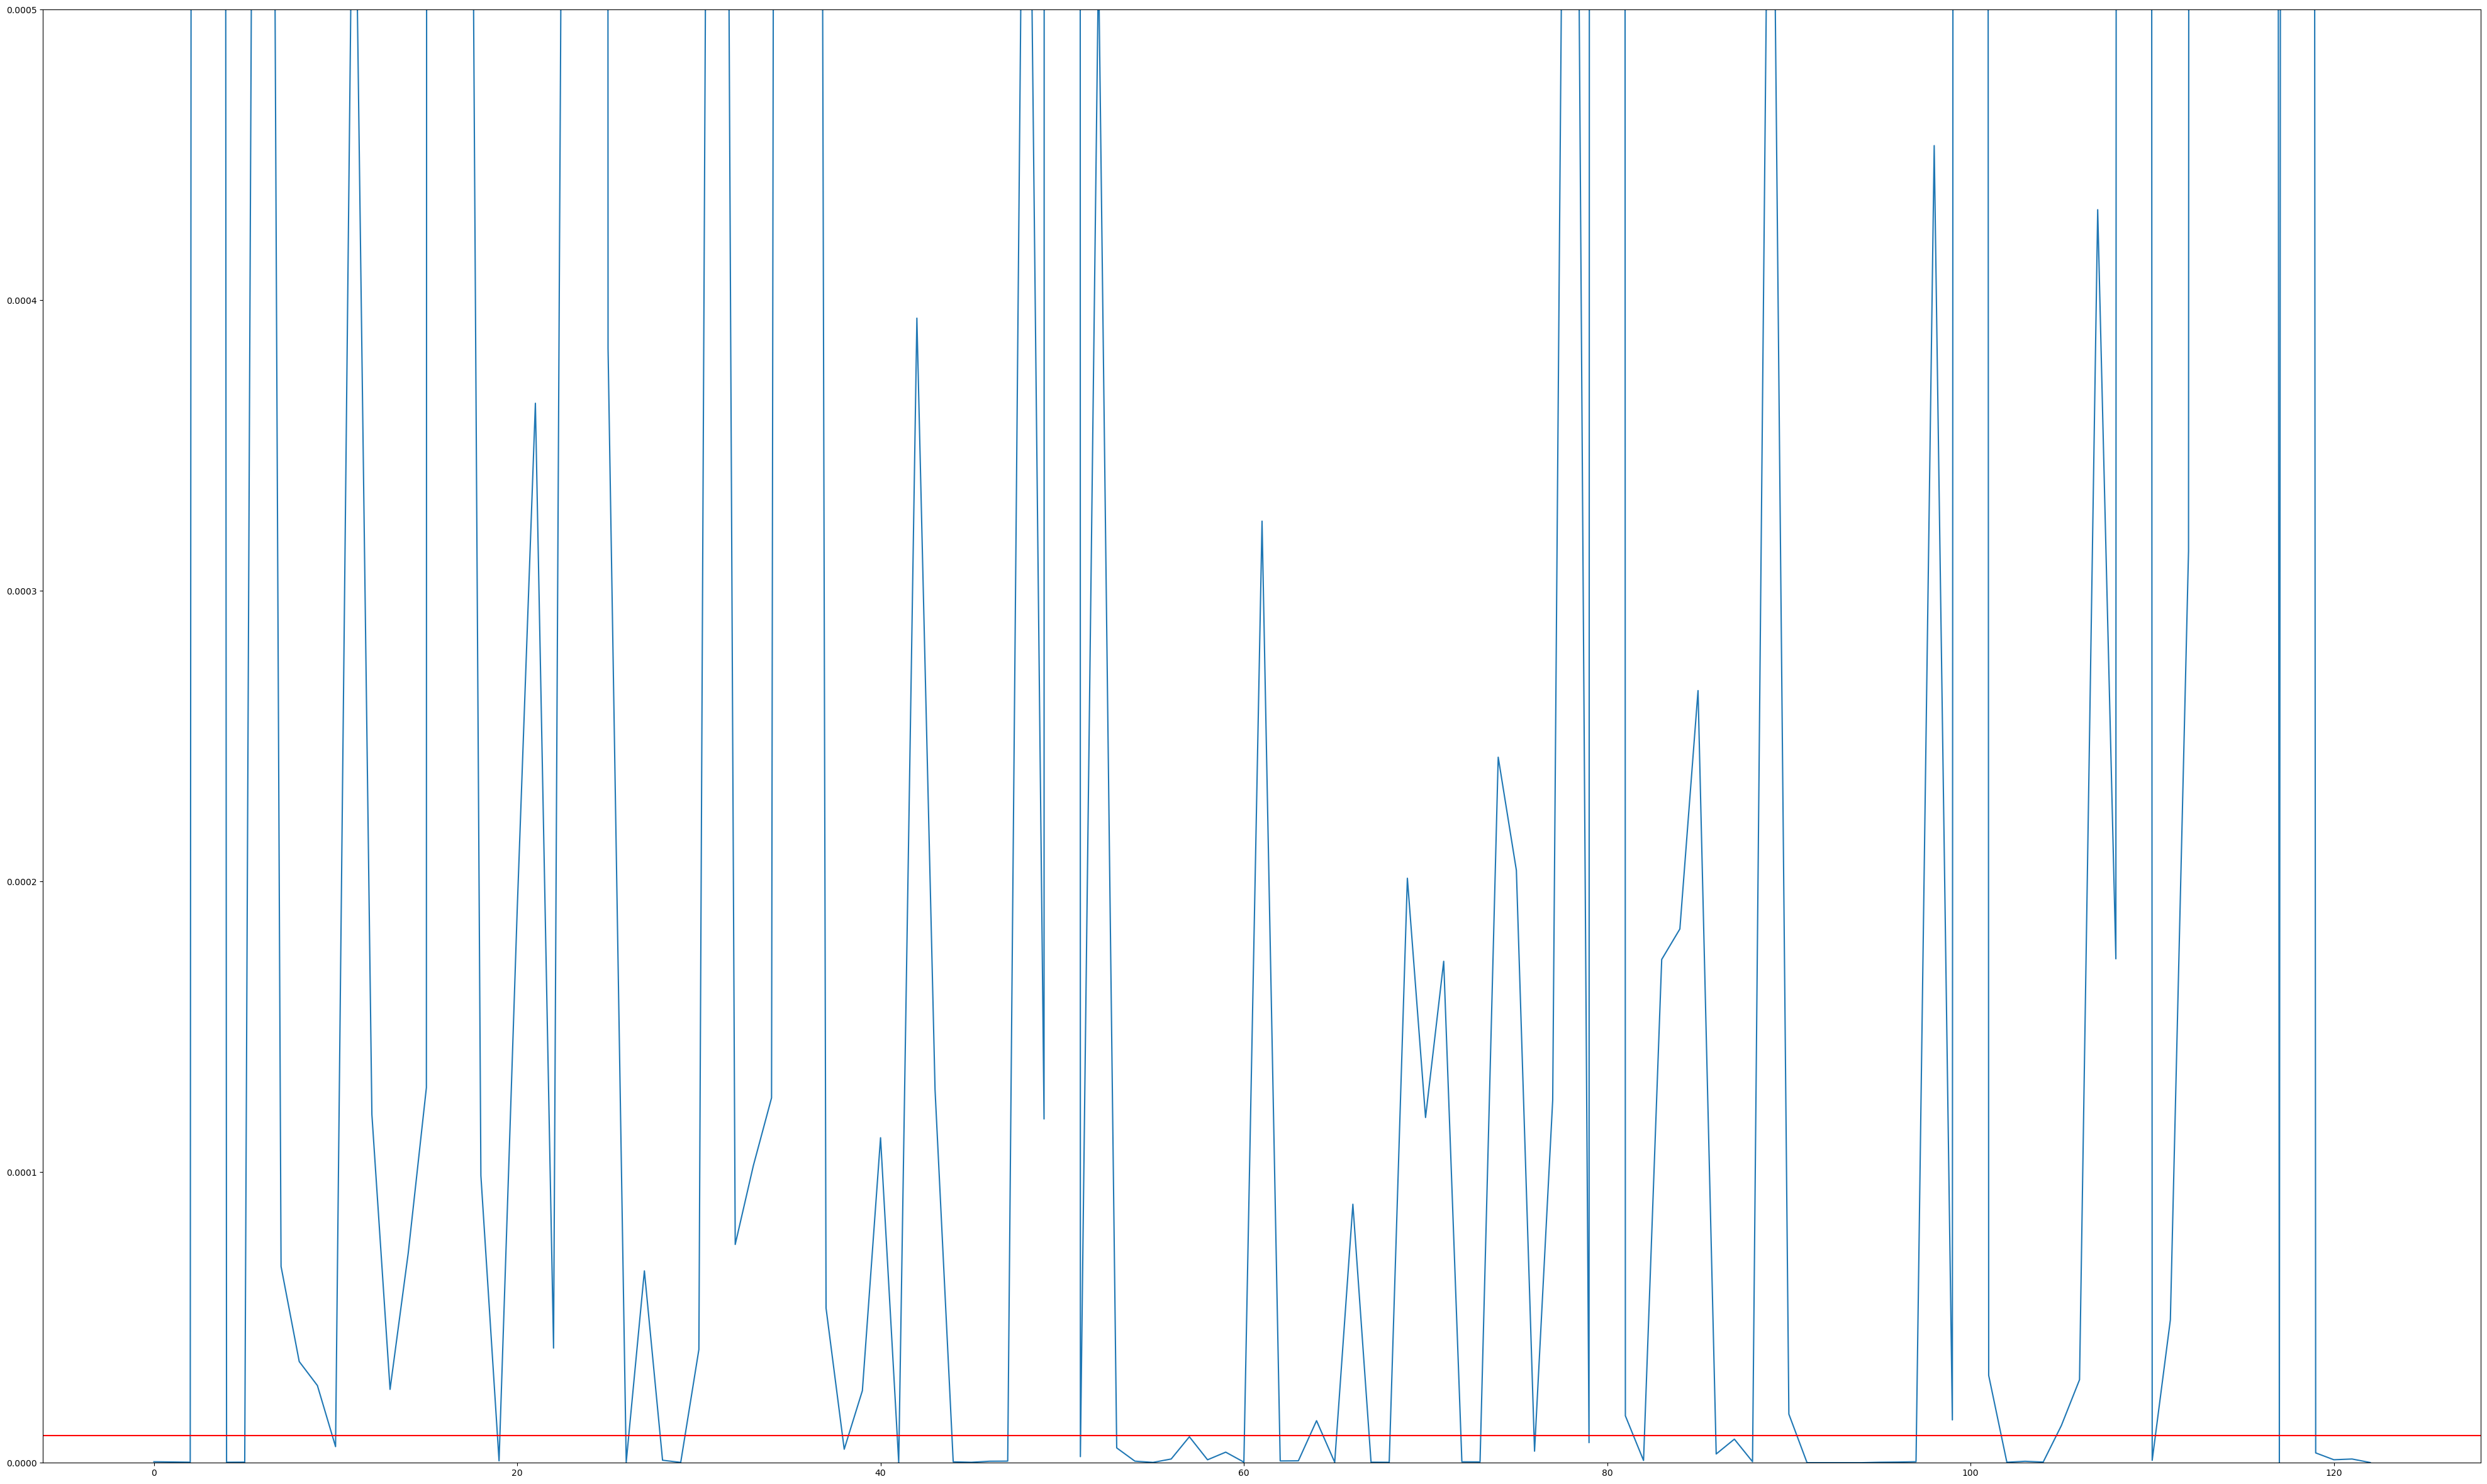

In [255]:
test_anomaly_count = 0
test_normal_count = 0
test_false_positive = 0
for i in range(len(mse_list_test_anomaly)):
    if mse_list_test_anomaly[i] > best_thr:
        test_anomaly_count = test_anomaly_count+1
for i in range(len(mse_list_test_normal)):
    if mse_list_test_normal[i] > best_thr:
        test_false_positive = test_false_positive + 1
        

        
print("Confusion matrix")
print(f"[{len(mse_list_test_normal)-test_false_positive} {test_false_positive}]\n[{len(mse_list_test_anomaly)-test_anomaly_count} {test_anomaly_count}]")
print(f"Detect Anomaly in Test Data : {str(test_anomaly_count)} / Whole Test Data {str(len(mse_list_test_anomaly))} ")
print(f"Precision : {test_anomaly_count/(test_anomaly_count + test_false_positive):.5f}")
print(f"Sensitivity : {1-test_false_positive/len(mse_list_test_normal):.5f}")
print(f"False-Positive Rate : {test_false_positive/len(mse_list_test_normal):.5f}")
plt.figure(figsize=(50,30))
plt.plot(mse_list_test_anomaly)
plt.ylim([0,0.0005])
plt.axhline(best_thr, color='r')
plt.show()